In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from causalimpact import CausalImpact
from statsmodels.tsa.seasonal import seasonal_decompose 

# Causal Impact 
Python implementation of Google's Causal Impact Library.

For a given set of observations and control observations, construct a Bayesian Structural Time-Series (BSTS) and perform posterior inference on the counterfactual to estimate the given magnitude of a defined intervention.

For reference, Structural Time-Series models are state-space models for time-series data, and can be defined by the following two equations:

\begin{align*}
&(1) \hspace{1cm} y_{t} = Z^T_{t} α_{t} + +βX_{t}+G_{t} \epsilon_{t} \\
&(2) \hspace{1cm} α_{t+1} = T_{t}α_{t} + R_{t}η_{t} \\
& \hspace{3cm} where \\ 
& \hspace{2cm} \epsilon_{t} ∼ N (0, \sigma^2_{t}) \\
& \hspace{3cm} and \\ 
& \hspace{2cm} η_{t} ∼ N(0,Q_{t}) \\
\end{align*} 
$$ \perp\perp$$ of all other unknowns.

Equation 1. is the observation equation; it links the observed data, y_t to a latent d-dimensional state vector, α_t. 

Equation 2. is the state equation; it governs the
evolution of the state vector, αt, through time and: 

*   y_t is a scalar observation 
*   Z_t is a d-dimensional output vector 
*   βX_t is a linear regression of covariates 
*   Tt is a d × d transition matrix 
*   Rt, Gt are d × q control matrices
*   εt is a scalar observation error with noise variance, σt, and: 
*   ηt is a q-dimensional system error with a q × q state-diffusion matrix,Qt, where q ≤ d. [K.H. Broderson et al, 2015](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41854.pdf))

For more information on state-space time-series you can refer to the [statsmodels](https://https://www.statsmodels.org/stable/statespace.html) documentation.

## Example - AR(2) process:

AR(2) definition:
$$y_{t}=ϕ1y_{t−1}+ϕ2y_{t}−2+ϵ_{t}, \\
where \hspace{1cm} ϵ_{t}∼N(0,σ^2)$$

In state-space form:

$$y_{t} = [1, 0]\alpha_{t}$$ \\

$$α_{t+1} = \begin{bmatrix} \phi_{1} & \phi_{2} \\ 1 & 0 \end{bmatrix} α_{t} + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta t$$ 

Where:
$$Z_{t} ≡ Z = \begin{bmatrix} 1 & 0 \end{bmatrix}$$

and:
$$T_{t} ≡ T = \begin{bmatrix} \phi_{1} & \phi_{2} \\ 1 & 0 \end{bmatrix}$$
$$R_{t} ≡ R = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$$
$$\eta_{t} ≡ \epsilon_{t+1}∼N(0,σ^2)$$

# Vale Dam Incident, Córrego do Feijão mine
This colab is intended to demonstrate the utility of Google's Causal Impact package in estimating the impact of an event on a response time-series. 

In this instance, we are estimating the impact of the Vale dam incident that occured at Vale's (the worlds largest producer of Iron ore) Córrego do Feijão mine on spot price of Iron ore. 

Whilst modelling the outcome of any financial time-series is generally a highly-complicated, non-linear problem requiring far greater consideration, the intention of this demonstration to illustrate the utility and expediency at which CI can perform such an analysis and its ability to fully quantify its output.


In [ ]:
#@title Get Data
df = pd.read_excel(
    '/Users/CP/Desktop/IO_Spot_2015010120200501.xlsx',
    index_col='date',
)

In [ ]:
df.tail(5)

,close,close_252d_rolling,close_21d_rolling,returns
date,,,,
2020-05-04,82.04,93.850595,83.550952,-1.80
2020-05-05,82.93,93.804881,83.601429,0.89
2020-05-06,83.18,93.764008,83.648095,0.25
2020-05-07,84.73,93.724683,83.756667,1.55
2020-05-08,87.18,93.689206,84.019048,2.45


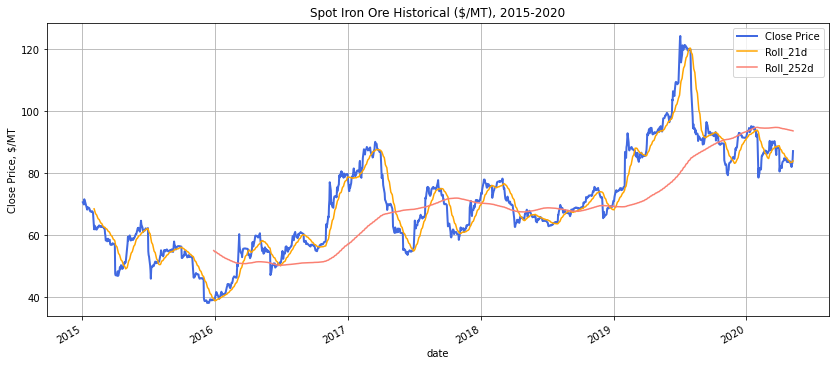

In [ ]:
#@title Plot Close Price
df['close'].plot(lw=2., figsize=(14,6), label='Close Price',c='royalblue')
df['close'].rolling(21).mean().plot(lw=1.5, label='Roll_21d',c='orange')
df['close'].rolling(252).mean().plot(lw=1.5, label='Roll_252d', c='salmon')
plt.title('Spot Iron Ore Historical ($/MT), 2015-2020')
plt.ylabel('Close Price, $/MT')
plt.grid(); plt.legend()

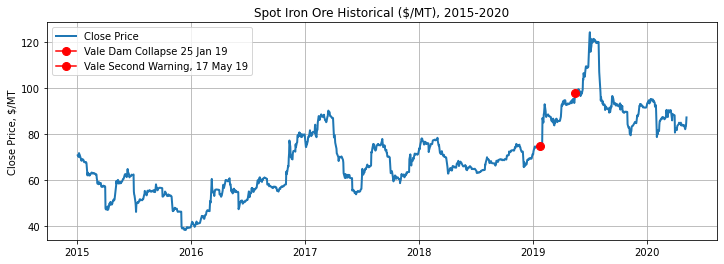

In [ ]:
#@title Vale Dam & Second Warning
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df['close'], lw=2., label='Close Price')
ax.plot(df['close'][df.index == '2019-01-25'], 
        marker='o', color='r', markersize=8,
        label='Vale Dam Collapse 25 Jan 19')
ax.plot(df['close'][df.index == '2019-05-17'], 
        marker='o', color='r', markersize=8,
        label='Vale Second Warning, 17 May 19')
plt.title('Spot Iron Ore Historical ($/MT), 2015-2020')
plt.ylabel('Close Price, $/MT')
plt.grid(); plt.legend()

# Causal Impact -  Local Level Only

Model definition:

$$y_{t} = μ_{t}+ γ_{t} +βX_{t}+ϵ_{t}$$ 
$$μ_{t+1} = μ_{t} + η_{μt}$$

Observe that a point in time is modelled by a random walk component: $$\mu t$$.

Seasonality: $$\gamma t$$ 

is modelled using the [statsmodels seasonal model](https://www.statsmodels.org/stable/statespace.html)

### Basic Analysis
*   21 and 252d MA spot price pre and post-period
*   Std prior to event (note that dataset variance is used by CI in defining model priors.


In [ ]:
df['close_252d_rolling'] = df['close'].rolling(252).mean()
df['close_21d_rolling'] = df['close'].rolling(21).mean() 

In [ ]:
pre_period = [df.index[0], '2019-01-24'] # Define pre-event period
post_period = ['2019-01-25', df.index[-1]] # Define post-event period

In [ ]:
pre_period_df = df[df.index <= '2019-01-24']
post_period_df = df[df.index >= '2019-01-25']
print('Pre-Event Statistics')
print(pre_period_df.describe())
print('Post-Event Statistics')
print(post_period_df.describe())

Pre-Event Statistics
             close  close_252d_rolling  close_21d_rolling      returns
count  1041.000000          790.000000        1021.000000  1040.000000
mean     63.088626           62.814798          62.915701     0.003894
std      10.871201            8.105428          10.600567     1.239456
min      38.150000           50.300119          38.897143    -9.360000
25%      55.440000           52.252698          55.479048    -0.280000
50%      62.900000           67.769385          62.958095     0.000000
75%      70.770000           69.194256          70.284762     0.360000
max      90.160000           72.029127          87.670000     8.750000
Post-Event Statistics
            close  close_252d_rolling  close_21d_rolling     returns
count  330.000000          330.000000         330.000000  330.000000
mean    92.537636           84.936674          92.243049    0.037758
std      9.770274            9.158178           9.371709    1.796627
min     74.720000           69.209048     

### CI Model

In [ ]:
# Instantiate CI model.
ci = CausalImpact(df['close'], pre_period, post_period)

C:\Users\CPrice2\Anaconda3\envs\base_copy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\CPrice2\Anaconda3\envs\base_copy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


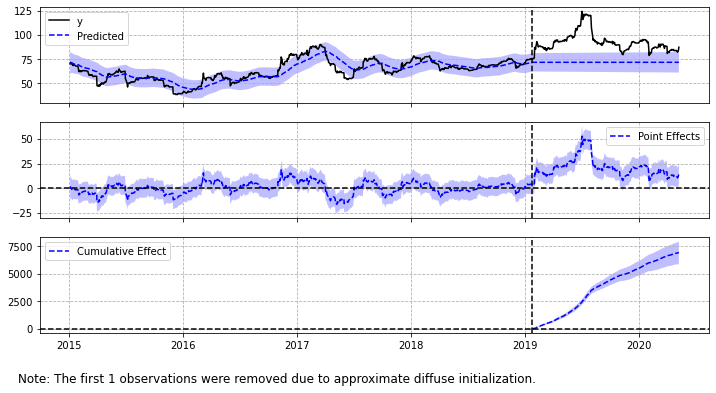

In [ ]:
ci.plot(figsize=(12, 6))

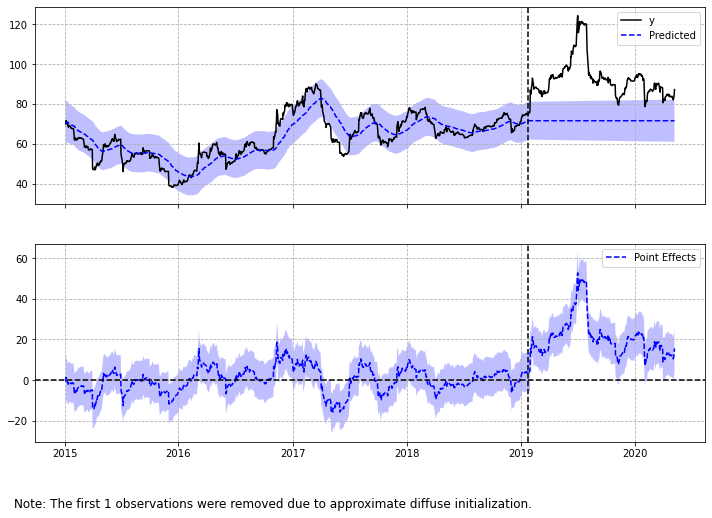

In [ ]:
# Plot counterfactual, and the 'pointwise' (cumulative) effect.
ci.plot(panels=['original', 'pointwise'], figsize=(12, 8))

In [ ]:
#@title Fitted Model Summary
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    92.54              30537.42
Prediction (s.d.)         71.57 (1.51)       23618.46 (499.32)
95% CI                    [68.56, 74.49]     [22625.42, 24582.7]

Absolute effect (s.d.)    20.97 (1.51)       6918.96 (499.32)
95% CI                    [18.04, 23.98]     [5954.72, 7912.0]

Relative effect (s.d.)    29.29% (2.11%)     29.29% (2.11%)
95% CI                    [25.21%, 33.5%]    [25.21%, 33.5%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
#@title Fitted Model Params
# Get trained model parameters and frac explained variance.
ci.trained_model.params

sigma2.irregular    0.193731
sigma2.level        0.000144
dtype: float64

In [ ]:
#@title Fitted Model Report 
print(ci.trained_model.summary())

                        Unobserved Components Results                         
Dep. Variable:                  close   No. Observations:                  786
Model:                    local level   Log Likelihood                -773.940
Date:                Mon, 21 Dec 2020   AIC                           1551.881
Time:                        11:42:40   BIC                           1561.212
Sample:                             0   HQIC                          1555.469
                                - 786                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.2480      0.011     22.662      0.000       0.227       0.269
sigma2.level         0.0001   8.78e-06     16.398      0.000       0.000       0.000
Ljung-Box (L1) (Q):         

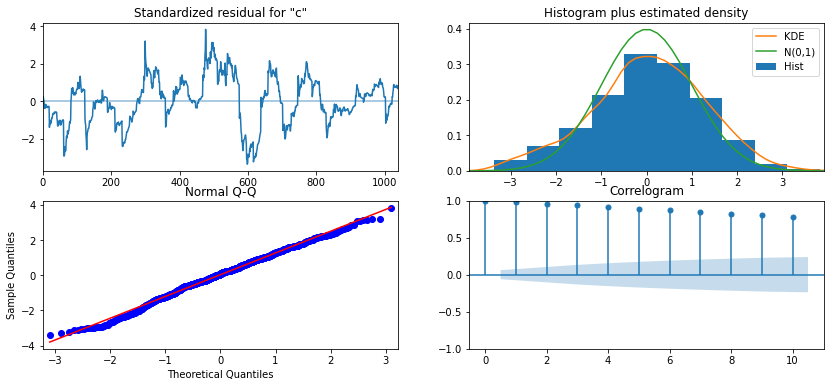

In [ ]:
#@title Plot Model Diagnostics
_ = ci.trained_model.plot_diagnostics(figsize=(14,6))

In [ ]:
ci.trained_model.specification

{'level': True,
 'trend': False,
 'seasonal_periods': 0,
 'seasonal': False,
 'freq_seasonal': False,
 'freq_seasonal_periods': [],
 'freq_seasonal_harmonics': [],
 'cycle': False,
 'ar_order': 0,
 'autoregressive': False,
 'irregular': True,
 'stochastic_level': True,
 'stochastic_trend': False,
 'stochastic_seasonal': True,
 'stochastic_freq_seasonal': [],
 'stochastic_cycle': False,
 'damped_cycle': False,
 'regression': False,
 'mle_regression': True,
 'k_exog': 0,
 'trend_specification': 'local level'}

# Causal Impact - Seasonal Variant.


<AxesSubplot:xlabel='date'>

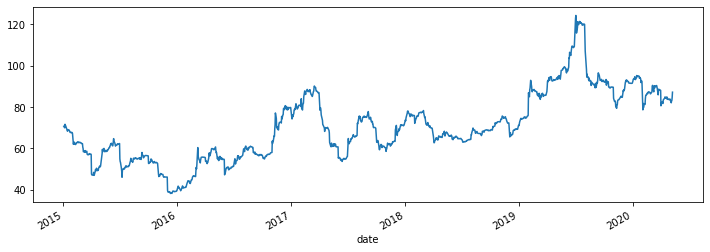

In [ ]:
#@title Plot spot price (Again)
df['close'].plot(figsize=(12,4))

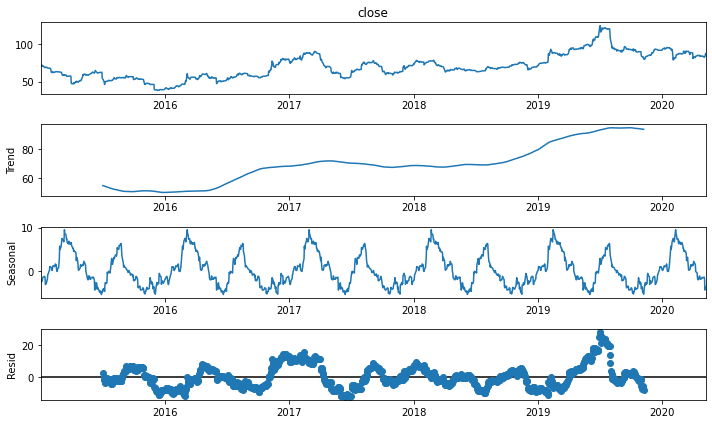

In [ ]:
#@title Seasonal Decompose
# Time series decomp to estimate seasonal comps, periodicity, amplitude etc.
s_dc = seasonal_decompose(df['close'], model='additive', period=252)
s_dc_plot = s_dc.plot()

Text(0.5, 1.0, 'Spot IO - Seasonal Component')

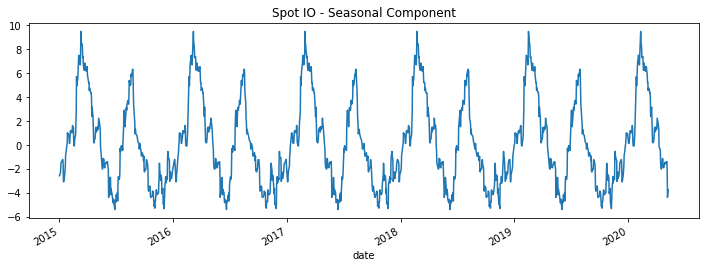

In [ ]:
# Isolate seasonal component
s_dc.seasonal.plot(figsize=(12,4))
plt.title('Spot IO - Seasonal Component')

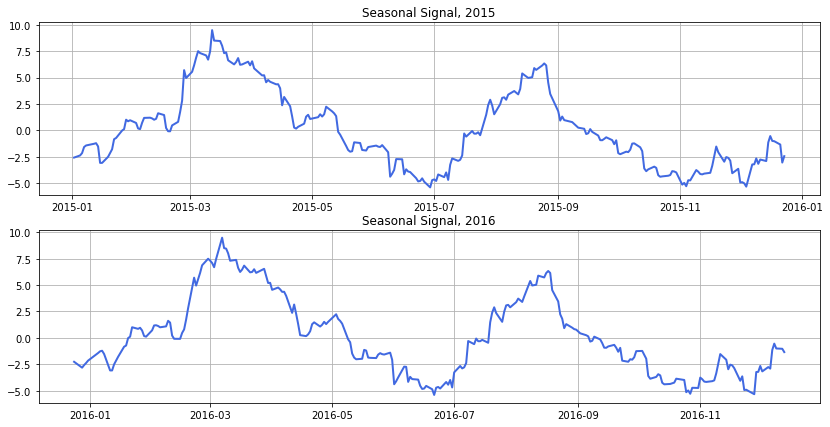

In [ ]:
#@title Seasonal Components: Isolated examples

seasonal_2015 = s_dc.seasonal[0:250]
seasonal_2016 = s_dc.seasonal[250:500]

fig, ax = plt.subplots(2, figsize=(14,7))
ax[0].plot(seasonal_2015, lw=2., color='royalblue')
ax[0].set_title('Seasonal Signal, 2015')
ax[1].plot(seasonal_2016, lw=2., color='royalblue')
ax[1].set_title('Seasonal Signal, 2016')
ax[0].grid(); ax[1].grid()

### Causal Impact Seasonal Model
Let's define our new model as one with a level component, and two seasonal components, one for our observed seasonality, consistent with the Chinese steel seasons, and one to account for any monthly cycles:

1. Level Component: $$\mu_{t}$$

2. Seasonal Component 1: Monthly (short) periodicity: 
$$\gamma^1_{t}$$ 

3. Seasonal Component 2: Bi-Annual (long) periodicity:
$$\gamma^2_{t}$$ 


Our model therefore:

$$y_{t} = \mu_{t} + \gamma^1_{t} + \gamma^2_{t}$$


In [ ]:
# Define CI Seasonal variant
ci = CausalImpact(
    df['close'], pre_period, post_period,
    nseasons=[
        {'period': 146, 'harmonics': 1},
        {'period': 22, 'harmonics': 1}]
)

C:\Users\CPrice2\Anaconda3\envs\base_copy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\CPrice2\Anaconda3\envs\base_copy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


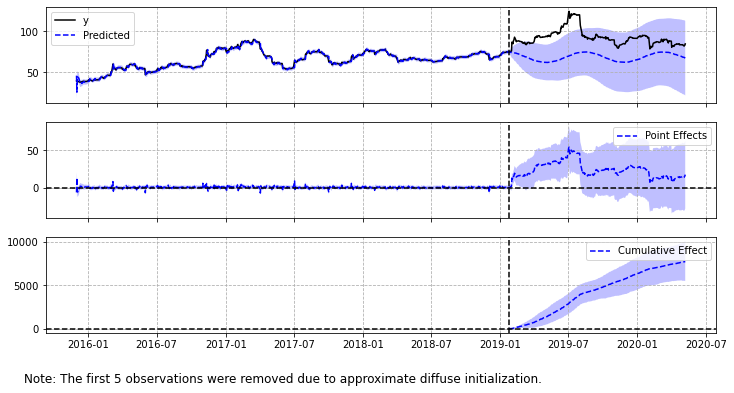

In [ ]:
ci.plot(figsize=(12, 6))

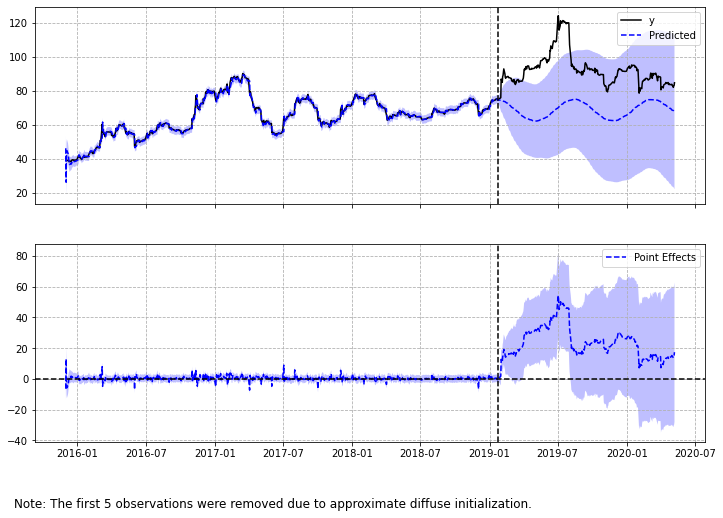

In [ ]:
ci.plot(panels=['original', 'pointwise'], figsize=(12, 8))

In [ ]:
ci.trained_model.params.round(5)

sigma2.irregular               0.00005
sigma2.level                   0.00014
sigma2.freq_seasonal_146(1)    0.01167
sigma2.freq_seasonal_22(1)     0.00000
dtype: float64

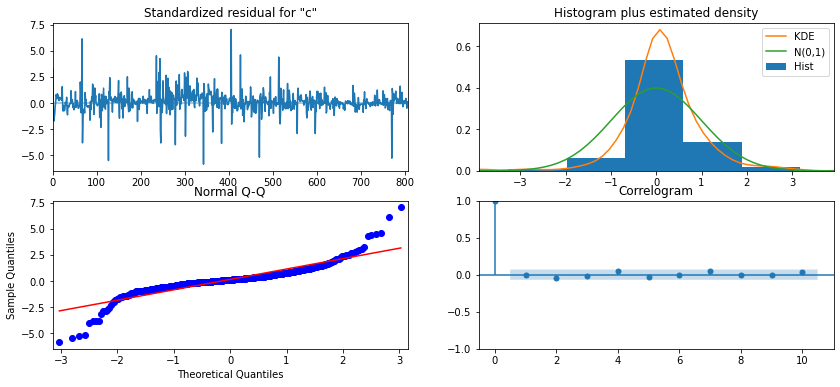

In [ ]:
_ = ci.trained_model.plot_diagnostics(figsize=(14,6))

# Causal Impact: Adding External Covariates (Features)
Seasonal components did little to improve the forecast counterfactual - the seasonal component definitions most certainly require adjusting.

We will attempt to improve the model with the addition of some known features fundamental to the supply/demand relationship of iron ore pricing. Recall that these will be added as a component: $$\beta X1_{t}, \beta X2_{t}$$ which is a  linear regression of these covariates help to explain our data:

*   Steel Scrap Spot Price
*   Chinese Domestic Rebar 

In [ ]:
spot_steel_scrap = pd.read_excel(
    '/Users/CP/Desktop/steel_scrap.xlsx',
    index_col='date',
    parse_dates=True,
)

In [ ]:
spot_rebar =  pd.read_excel(
    '/Users/CP/Desktop/steel_rebar.xlsx',
    index_col='dates',
    parse_dates=True,
)

In [ ]:
df_1 = pd.concat([df, spot_rebar, spot_steel_scrap],join='inner', axis=1)

In [ ]:
df_1.head(5)

,close,rebar_close,steel_scrap_close_usd
2015-11-24,46.17,2033,195.00
2015-11-25,46.11,2025,195.00
2015-11-26,46.17,2019,192.00
2015-11-27,46.09,2017,192.00
2015-11-30,46.10,1996,195.52


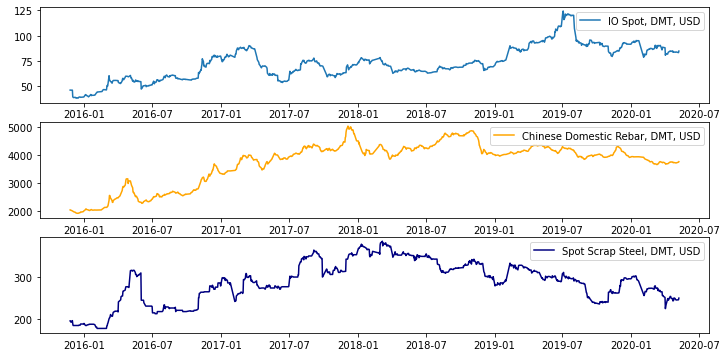

In [ ]:
#@title plot curves
df_1 = df_1[['close', 'rebar_close', 'steel_scrap_close_usd']]

# Plot curves
fig, ax = plt.subplots(3, figsize=(12, 6))
ax[0].plot(df_1['close'], label='IO Spot, DMT, USD')
ax[1].plot(df_1['rebar_close'], 
           label='Chinese Domestic Rebar, DMT, USD',
           color='orange')
ax[2].plot(df_1['steel_scrap_close_usd'], 
           label='Spot Scrap Steel, DMT, USD',
           color='navy')
ax[0].legend(); ax[1].legend(); ax[2].legend()

In [ ]:
pre_period = [df_1.index[0], '2019-01-24'] # Define pre-event period
post_period = ['2019-01-25', df_1.index[-1]] # Define post-event period

In [ ]:
ci_1 = CausalImpact(df_1, pre_period, post_period, nseasons=[{'period': 146}])

C:\Users\CPrice2\Anaconda3\envs\base_copy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\CPrice2\Anaconda3\envs\base_copy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\CPrice2\Anaconda3\envs\base_copy\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


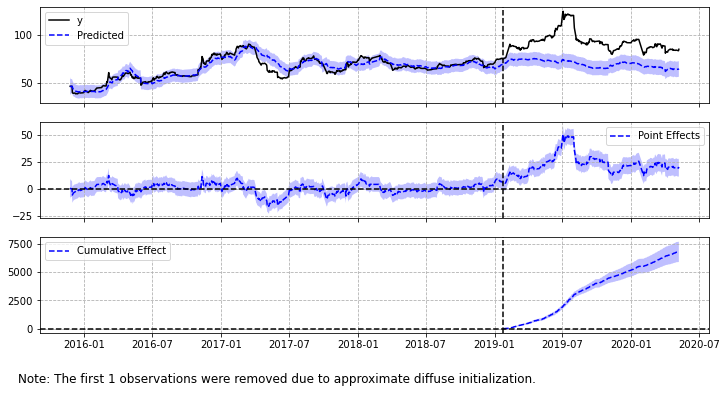

In [ ]:
ci_1.plot(figsize=(12, 6))

In [ ]:
print(ci_1.trained_model.summary())

                        Unobserved Components Results                         
Dep. Variable:                  close   No. Observations:                  744
Model:                    local level   Log Likelihood                -461.224
Date:                Sun, 03 Jan 2021   AIC                            930.448
Time:                        22:15:34   BIC                            948.891
Sample:                             0   HQIC                           937.557
                                - 744                                         
Covariance Type:                  opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular               0.0921      0.004     24.256      0.000       0.085       0.100
sigma2.level                   0.0001   6.19e-06     23.262      0.000       0.000 

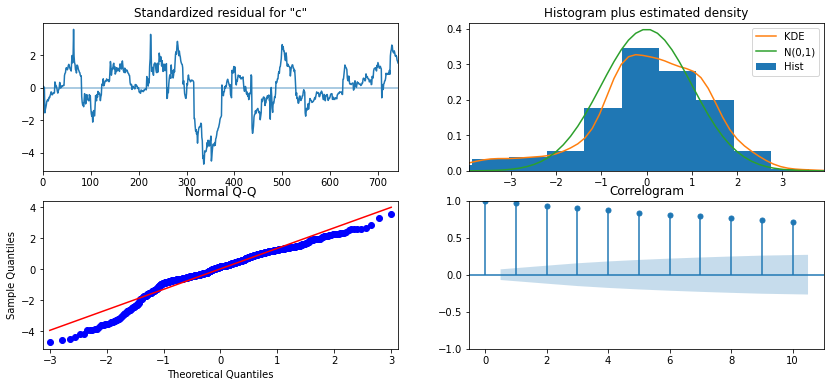

In [ ]:
#@title Plot Model Diagnostics
_ = ci_1.trained_model.plot_diagnostics(figsize=(14,6))

In [ ]:
print(ci_1.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 92.69. By contrast, in the absence of an
intervention, we would have expected an average response of 69.56.
The 95% interval of this counterfactual prediction is [66.47, 72.59].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 23.13 with a 95% interval of
[20.1, 26.21]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 27249.43.
By contrast, had the intervention not taken place, we would have expected
a sum of 20450.35. The 95% interval of this prediction is [19543.39, 21341.47].


The above results are given in terms of absolute numbers. In relative
terms, the response